In [74]:
import fxcmpy
import socketio
import quandl
import fxcmconfig as cfgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import IPython.display as IPydisplay
from PIL import Image
import tqdm

In [3]:
eur_jpy_data = pd.read_csv('./data/eur_jpy_m15_20200404_20201101.csv')

# create a single `open', `close', `high', `low' metrics with bid/ask prices 
eur_jpy_data.loc[:,'open'] = (eur_jpy_data.bidopen + eur_jpy_data.askopen)/2 
eur_jpy_data.loc[:,'close'] = (eur_jpy_data.bidclose + eur_jpy_data.askclose)/2 
eur_jpy_data.loc[:,'high'] = (eur_jpy_data.bidhigh + eur_jpy_data.askhigh)/2 
eur_jpy_data.loc[:,'low'] = (eur_jpy_data.bidlow + eur_jpy_data.asklow)/2 
#eur_jpy_data.loc[:,'avg_price'] = (eur_jpy_data.open + eur_jpy_data.close)/2 

# reformat date to date-time
eur_jpy_data.date = pd.to_datetime(eur_jpy_data.date)

In [4]:
# filter out only the required metrics / structure the dataframe
eur_jpy_data = eur_jpy_data.loc[:,['date','open','close','high','low','tickqty'
                                  # ,'avg_price'
                                  ]]
eur_jpy_data.columns = ['date','open','close','high','low','volume'
                       # ,'avg_price'
                       ]

eur_jpy_data.set_index('date',inplace = True)
eur_jpy_data.sort_index(inplace=True)

In [5]:
# create basic moving-average indicators (50 EMA 200 EMA)
eur_jpy_data['ewm_50_m'] = eur_jpy_data['close'].ewm(span=50
                                                   , min_periods=0
                                                   , adjust=False
                                                   , ignore_na=False).mean()
eur_jpy_data['ewm_50_h'] = eur_jpy_data['high'].ewm(span=50
                                                   , min_periods=0
                                                   , adjust=False
                                                   , ignore_na=False).mean()
eur_jpy_data['ewm_50_l'] = eur_jpy_data['low'].ewm(span=50
                                                   , min_periods=0
                                                   , adjust=False
                                                   , ignore_na=False).mean()

eur_jpy_data['ewm_200'] = eur_jpy_data['close'].ewm(span=200
                                                   , min_periods=0
                                                   , adjust=False
                                                   , ignore_na=False).mean()


In [6]:
eur_jpy_data.head()

,open,close,high,low,volume,ewm_50_m,ewm_50_h,ewm_50_l,ewm_200
date,,,,,,,,,
2020-04-05 21:00:00,117.2270,117.2105,117.2235,117.1625,30,117.210500,117.223500,117.162500,117.210500
2020-04-05 21:15:00,117.2105,117.1725,117.2335,117.1640,22,117.209010,117.223892,117.162559,117.210122
2020-04-05 21:30:00,117.1725,117.3025,117.3185,117.2590,32,117.212676,117.227602,117.166341,117.211041
2020-04-05 21:45:00,117.3025,117.2465,117.3215,117.2270,51,117.214003,117.231285,117.168720,117.211394
2020-04-05 22:00:00,117.2465,117.3945,117.4345,117.1465,4570,117.221081,117.239254,117.167848,117.213216


In [43]:
# create 6 candle-stick idx chunks
data_idx_chuncks = [i for i in zip(eur_jpy_data.index.to_list(), eur_jpy_data.index.to_list()[6:])]

In [149]:
def buy_signal(df):
    """Buy signal at the 3rd candle-stick open (i.e., 2nd candle-stick close)"""
    df.sort_index(inplace=True)
    
    temp_dic = {}
    
    i = 0
    for idx, row in df.iterrows():
        temp_dic[f't_{i}'] = row
        i+=1

    signal_vec = [] 

    # t = -1 | past 
    s1 = temp_dic['t_0'].close <= temp_dic['t_1'].open # t-1[close] < t-1[open]

    # t = 0 | present
    s2 = temp_dic['t_1'].close > temp_dic['t_1'].open # t[close] > t[open]
    s3 = temp_dic['t_1'].close > temp_dic['t_1'].low  # t[close] > t[low]

    signal_vec.append(np.array([s1,s2,s3]).sum() == 3) 
    
    # t = 1,2,3,4 | future
    for i in [2,3,4,5]:

        s1 = temp_dic[f't_{i}'].close  > temp_dic[f't_{i}'].open   # t+1[close] > t+1[open]
        s2 = temp_dic[f't_{i}'].close  > temp_dic[f't_{i}'].low    # t+1[close] > t+1[low]
        s3 = temp_dic[f't_{i}'].high  >= temp_dic[f't_{i}'].close  # t+1[high] > t+1[close]

        s4 = temp_dic[f't_{i}'].high  >= temp_dic[f't_{(i-1)}'].high # t+1[high] > t[high]
        s5 = temp_dic[f't_{i}'].low   >= temp_dic[f't_{(i-1)}'].low  # t+1[low]  > t[low]

        if i == 5:
            s6 = (temp_dic[f't_5'].close - temp_dic[f't_2'].open) > 0.0025 # 20 pips
            signal_vec.append(np.array([s1,s2,s3,s4,s5,s6]).sum() == 6)
            continue

        signal_vec.append(np.array([s1,s2,s3,s4,s5]).sum() == 5)

    tmp_df = pd.DataFrame(df.iloc[1,]).T
    
    if sum(signal_vec) == 5:
        tmp_df.loc[:,'signal'] = 'BUY'
        tmp_df.loc[:,'signal_count'] = sum(signal_vec)
    else:
        tmp_df.loc[:,'signal'] = 'HOLD'
        tmp_df.loc[:,'signal_count'] = sum(signal_vec)
        
    return tmp_df

In [150]:
final = []

for data_chunk in tqdm.tqdm(data_idx_chuncks):
    final.append(buy_signal(eur_jpy_data.loc[data_chunk[0]:data_chunk[1]]))
    
final_df = pd.concat(final)


100%|███████████████████████████████████████████████████████████████████████████| 14418/14418 [01:04<00:00, 223.05it/s]


In [151]:
final_df.signal.value_counts()

HOLD    14260
BUY       158
Name: signal, dtype: int64

In [152]:
final_df.loc['2020-10-30 11:30:00	':'2020-10-30 12:45:00']

# image input should display candle-sticks until the time of creating the signal (i.e., the row)

,open,close,high,low,volume,ewm_50_m,ewm_50_h,ewm_50_l,ewm_200,signal,signal_count
2020-10-30 11:30:00,121.9055,121.8930,121.9175,121.8695,3345.0,121.929041,121.970221,121.885529,122.301778,HOLD,3.0
2020-10-30 11:45:00,121.8930,121.9175,121.9225,121.8500,3726.0,121.928589,121.968349,121.884136,122.297954,BUY,5.0
2020-10-30 12:00:00,121.9175,121.9225,121.9275,121.8580,3571.0,121.928350,121.966747,121.883111,122.294218,BUY,5.0
2020-10-30 12:15:00,121.9225,121.9265,121.9375,121.8755,3160.0,121.928277,121.965600,121.882813,122.290559,HOLD,4.0
2020-10-30 12:30:00,121.9265,121.9525,121.9580,121.9100,3940.0,121.929227,121.965302,121.883879,122.287195,HOLD,3.0
2020-10-30 12:45:00,121.9525,122.2240,122.2355,121.9150,7624.0,121.940787,121.975898,121.885099,122.286567,HOLD,2.0


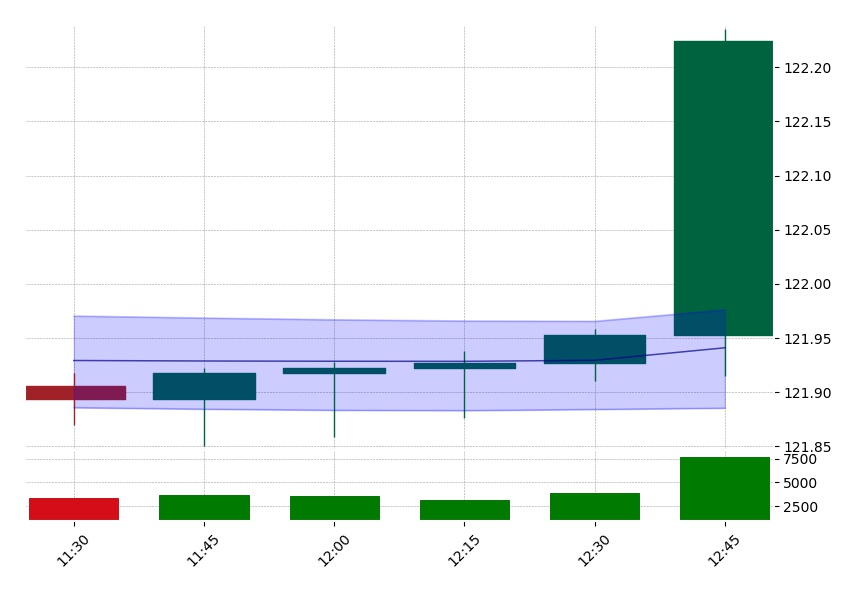

In [146]:
# generate a sample candle-stick image with indicators

temp_df = final_df.loc['2020-10-30 11:30:00	':'2020-10-30 12:45:00']

#tcdf = temp_df[['ewm_50_h','ewm_50_l','ewm_50_m','ewm_200']]  # DataFrame with two columns
#apd  = mpf.make_addplot(tcdf)
#mpf.plot(df,addplot=apd)


apds = [mpf.make_addplot(temp_df['ewm_50_h']
                         #, linestyle ='dashdot'
                         , color = 'blue'
                         , alpha = 0.2),
        mpf.make_addplot(temp_df['ewm_50_m']
                         #, linestyle ='dashdot'
                         , color = 'darkblue'
                         , alpha = 0.7),
        mpf.make_addplot(temp_df['ewm_50_l']
                         #, linestyle ='dashdot'
                         , color = 'blue'
                         , alpha = 0.2),
        mpf.make_addplot(temp_df['ewm_200']
                         #, linestyle ='line'
                         , color='red')
       ]

s  = mpf.make_mpf_style(base_mpf_style='charles'
                        , gridstyle = 'dashed')

test = mpf.plot(temp_df
                  , type = 'candle'
                  , style = s
                  , volume = True
                  #, figscale=1
                  #, title='Apple, March - 2020'
                  , ylabel=''
                  , ylabel_lower=''
                  #, xrotation=90
                  #, figsize = (7,4)
                  , figratio = (12,8)
                  , tight_layout = True
                  , addplot = apds
                  , panel_ratios = (6,1)
                  #, show_nontrading = True
                  , fill_between = dict(y1 = temp_df['ewm_50_h'].values
                                        , y2 = temp_df['ewm_50_l'].values
                                        , alpha=0.2
                                        , color='b')
                  , scale_width_adjustment = dict(volume=0.7
                                                  , candle=1.2
                                                  , lines=0.3)
                  , savefig=dict(fname='chart.jpg'
                                 , dpi=100
                                 , pad_inches=0.25))

IPydisplay.Image(filename='chart.jpg')

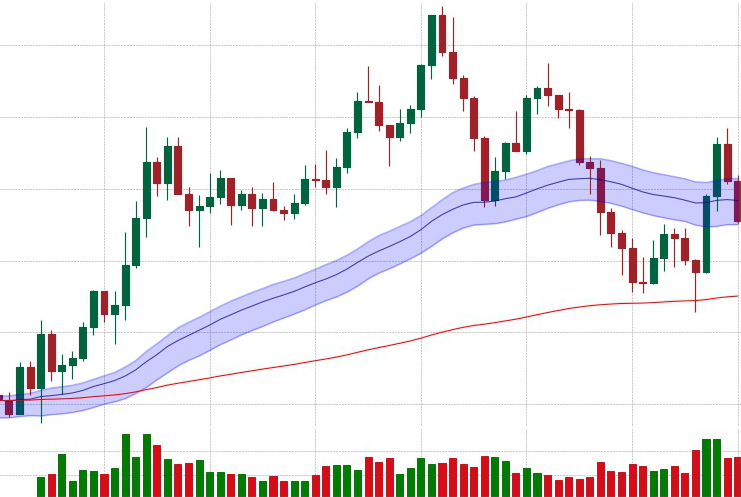

In [308]:
img = Image.open('chart.jpg')
w, h = img.size
img.crop((65, 22, w-80, h-113))

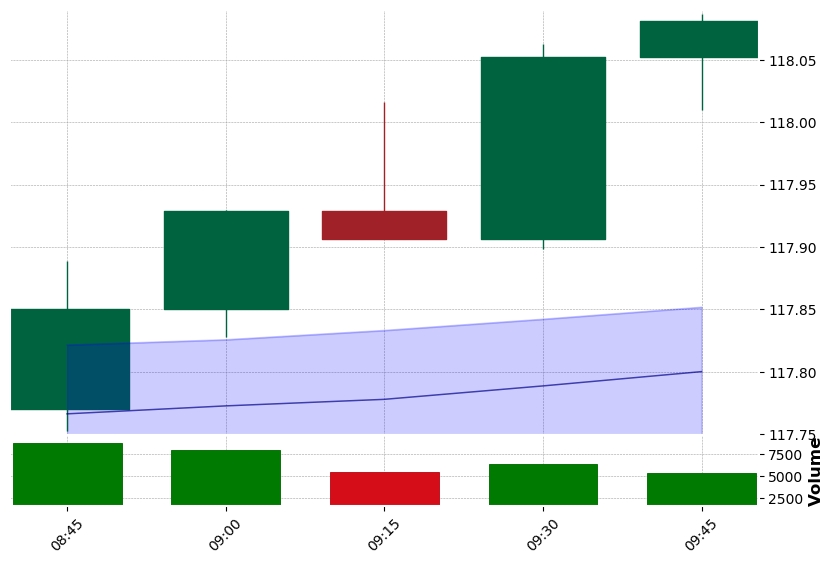

In [222]:
temp_df = eur_jpy_data.iloc[47:52,:]

#tcdf = temp_df[['ewm_50_h','ewm_50_l','ewm_50_m','ewm_200']]  # DataFrame with two columns
#apd  = mpf.make_addplot(tcdf)
#mpf.plot(df,addplot=apd)


apds = [mpf.make_addplot(temp_df['ewm_50_h']
                         #, linestyle ='dashdot'
                         , color = 'blue'
                         , alpha = 0.2),
        mpf.make_addplot(temp_df['ewm_50_m']
                         #, linestyle ='dashdot'
                         , color = 'darkblue'
                         , alpha = 0.7),
        mpf.make_addplot(temp_df['ewm_50_l']
                         #, linestyle ='dashdot'
                         , color = 'blue'
                         , alpha = 0.2),
        mpf.make_addplot(temp_df['ewm_200']
                         #, linestyle ='line'
                         , color='red')
       ]


mpf.plot(temp_df
          , type = 'candle'
          , style = 'charles'
          , volume = True
          #, figscale=1
          #, title='Apple, March - 2020'
          , ylabel=''
          #, figsize = (7,4)
          , figratio = (12,8)
          , tight_layout = True
          , addplot = apds
          , panel_ratios = (6,1)
          #, show_nontrading = True
          , fill_between = dict(y1 = temp_df['ewm_50_h'].values
                                , y2 = temp_df['ewm_50_l'].values
                                , alpha=0.2
                                , color='b')
          , scale_width_adjustment = dict(volume=0.7
                                          , candle=1.2
                                          , lines=0.3)
          )